## Arirang 데이터 분석 툴

_최근 수정 2023.12.26 05:56_

In [1]:
from pykoges import codingbook, koges, stats, model

1. 코딩북 읽기

In [2]:
q = codingbook.read(folder_name='./data_fixed/')
q.summary()

코딩북 읽어오는중...:   0%|          | 0/20 [00:00<?, ?it/s]

#### 실행결과
***
#### 1. 전체 질문데이터
***
- 전체 질문 데이터 **19409**개
- 객관식 데이터 **10198**개 / 주관식 데이터 **9211**개
- 코드 중복 제거시 **2764**개
- 연도별 질문 개수

||05|06|07|08|09|10|11|12|13|14|15|16|17|20|21|22|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|baseline 질문 수|907|907|907|1268|995|1041|1047|0|0|0|0|0|0|0|0|0|
|track 질문 수|0|0|0|917|917|917|969|969|995|607|365|725|456|1500|1500|1500|
***
#### 3. 예시 데이터
***
- 질문 데이터
```json
{
    "survey_name": "",
    "survey_name_korean": "",
    "survey_code": "ph1_instype",
    "has_options": "o",
    "variable_type": "n",
    "variable_length": "1",
    "question_text": "의료보장형태",
    "question_type": "s",
    "answer": {
        "1": "공교",
        "2": "직장",
        "3": "지역",
        "4": "의료보호",
        "9": "미상/무응답"
    },
    "data_type": "baseline",
    "year": "05"
}```


2. 변수 설정

In [3]:
x_list = {
    "stiffness", "bonet", "bonez",  # bone stiffness/T/Z
    
    "glu0",  # glucose, 결측치가 많아서 폐기
    "uricacid",  # gout
    "insul_fbs", # insulin(fbs)
    # 호흡
    "fvc", "fev1", #"fef25",
    # 신체계측
    "waist", "hip", "bparmc",
    "weight", "height", # bmi가 필요하면 이 두개로 생성
    # 신장
    "bun", "creatine",
    # "u_ph",
    # "glu16_u",
    # 대사
    "ldl", "tg", "hdl", "tchl",  # cholesterol
    "albumin",  # albumin
    "ast", "alt", "r_gtp",
    # "t_bil", 
    # "u_ket", # 결측치 많아서 폐기

    # 순환
    "rabi", "labi", "pulse", # right/left ABI
    # 기초
    "age",
    # "grwhich", "gripl1", "gripr1", # 주 사용손/왼손/오른손 악력
    
    # CBC 지표
    "hb", "hct",
    "mcv", "mch", "mchc",
    "rbc", "wbc", "plat",

    "crp",
    "muscle",
    # "incell", "excell", "pbf", #inbody, muscle을 예측할때 제외

    "smam", "smdudy", "smdumo", "smduyr", "smdu", # 일일 흡연량, 흡연기간
    "drinkfq", "drinkam", # 음주빈도, 음주량
    "sex"
}

y_list = {
    # "muscle" # 근육량
    "gripr1", "gripl1", "grwhich",  # 악력, 성별에 따라 분류
    # "ekg",  # OX, EKG이상
    # "dm" # OX, 당뇨
    # "code1", # 이산, EKG소견 (미네소타 코드)

    # "hba1c", # 연속 
    # "glu0" # 연속, 결측치가 많아서 폐기
    # "glu_fbs" # 연속, 결측치가 많아서 폐기
    # "strk4", # OX, dysphagia, 결측치가 많아서 폐기
    # 'nuchronic5' # OX, 골다공증, 결측치가 많아서 폐기
}

# 중복되는 환자 데이터를 통합하기 위해 사용하는 변수
patientinfo_list = {
    "cp", # 휴대폰 번호
    "name",  # 이름
    "sex", # 성별
    "birthday",  # 생년월일
    "socialno1",  # 주민번호 앞자리
    "socialno2",  # 주민번호 뒷자리
}

var = koges.Variables(
    q=q,
    x_list=x_list,
    y_list=y_list,
    patientinfo_list=patientinfo_list,
)
var.summary(
    display_datainfo=False,
    display_userinfo=False,
)

2. 데이터 읽기

In [4]:
kg = koges.read(
    variables=var,
    folder_name='./data_fixed/',
    filter_patient=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

3. 데이터 전처리

In [23]:
from pykoges.utils import div, mul

eps = 1e-9
y = kg.y[0]
custom_functions = []
if y == "dm": #dm여부
    custom_functions = [
        (["hb", "plat"], div),
        (["bun", "ldl"], div),
        (["ast", "tchl"], div),
        (["bonet", "bonez"], lambda a, b: (b * (b - a)) ** 2),
        (["stiffness", "height"], lambda a, b: b * (b - a) ** (1 / 2)),
        (["uricacid", "t_bil"], div),
        (["fev1", "fvc"], lambda a, b: a / (a + b + eps) * 100),
        # (['fvc', 'fev1', 'hct', 'plat'], lambda a,b,c,d:(a+b)*(c+d)),
    ]
elif y == "ekg": #ekg여부
    custom_functions = [
        (["bonet", "bonez"], lambda a, b: (b * (b - a)) ** 2),
        (["fev1", "fvc"], lambda a, b: a / (a + b + eps) * 100),
        (["muscle", "weight"], lambda a, b: (b * (b - a))),
        (["ast", "tchl"], mul),
        (["hb", "hct"], mul),
        (["height", "pulse"], lambda a, b: (b * (a - b))),
        (["alt", "ldl"], lambda a, b: (b - a) / (b + a + eps) * 100),
    ]
elif y == "code1": #ekg소견
    custom_functions = [
        (["hb", "hct"], div),
        (["ast", "alt"], div),
        (["muscle", "hdl"], div),
        # (["albumin", "alt"], div),
        # (["hdl", "tchl"], div),
        # (["tg", "tchl"], div),
        (["bun", "creatine"], mul),
    ]
elif y.startswith('gr'): #악력
    custom_functions = [
        # (["wbc", "mcv"], div),
        # (["alt", "tg"], div),
        # (["ast", "alt"], div),
        # (["plat", "mchc"], div),
        # (["mcv", "mchc"], div),
        # (["mch", "mchc"], div),
        # (["bparmc", "abi"], div),
        # (["smokepy", "glu0"], div),
        # (["glu0", "albumin"], mul),
        # (["bun", "u_ph"], div),
    ]

kg_converted = koges.convert(
    koges=kg,
    muscle_weight_ratio=False,
    muscle_height_ratio=False,
    muscle_bmi_ratio=False,
    waist_hip_ratio=True,
    fev_fvc_ratio=False,
    grip_of_grwhich=True,
    abi_of_grwhich=True,
    weight_height_bmi=False,
    custom_functions=custom_functions,
)

In [24]:
kg_dropped = koges.drop(
    koges=kg_converted,
    drop_threshold=0.3,
    # filter_alpha=3,
    data_impute=False,
    #
    display_result=True,
    display_count=True,
)

,데이터,비율,변수
전체 데이터,6987,100%,39
Y값 결측치 제거,-6074,-86%,
결측치 30% 이상인 입력변수 제거,,,-8
결측치 제거,-6079,-87%,
최종데이터,908,12%,31


데이터 개수
track 22     303
      21     303
      20     302
total        908

### 4. 통계분석

#### 1) 데이터 분리

In [40]:
# custom split, 나머지는 정상으로 분류됩니다.
y = kg_dropped.y[0]
custom_split = {}

if y == "grip":
    custom_split = {
        "남성, Sarcopenia": lambda x: (
            (x["sex"] == 1) & (x[y] < 28) & (x["muscle"] < 7 * x["height"])
        ),
        "남성, 정상": lambda x: (x["sex"] == 1),
        "여성, Sarcopenia": lambda x: (
            (x["sex"] == 2) & ((x[y] < 18) & (x["muscle"] < 5.7 * x["height"]))
        ),
        "여성, 정상": lambda x: (x["sex"] == 2),
    }
    # custom_split = {
    #     "Sarcopenia": lambda x: 
    #     ((x["sex"] == 1) & (x[y] < 28) & (x["muscle"] < 7 * x["height"])) | ((x["sex"] == 2) & (x[y] < 18) & (x["muscle"] < 5.7 * x["height"])),
    # }

kg_splitted = stats.split(
    koges=kg_dropped,
    n_class=3,
    p_threshold=0.05,
    with_normality=False,
    with_homogenity=False,
    isdisplay=True,
    custom_split=custom_split,
    dispaly_y=" ",
)

#### 2) 통계분석

In [41]:
if kg_splitted.n_class == 2:
    kg_stats = stats.t_test(koges=kg_splitted, p_threshold=.05)
else:
    kg_stats = stats.anova(koges=kg_splitted, p_threshold=.05)

-----------------------
유효변수 22개
Age, Albumin, 팔둘레, BUN, Creatine, 주당음주량, Hb, Hct, HDL, 키, MCH, MCHC, MCV, 근육량, PLT, γ-GTP, RBC, Cholesterol, UA, WBC, 체중, WHR


C:\Users\kjunh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\kjunh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [42]:
stats.summary(koges=kg_stats, isdisplay=True, p_threshold=.05)

-----------------------
ANOVA 결과


In [43]:
stats.boxplot(koges=kg_stats, isdisplay=False)

In [44]:
stats.correlation(koges=kg_stats, isdisplay=False)

In [45]:
stats.scatter(koges=kg_stats, isdisplay=False)

### 5. 머신러닝

,LinearRegression
Scaler,MinMaxScaler
MAE,3.7167
MSE,21.4213
R2 score,0.5807


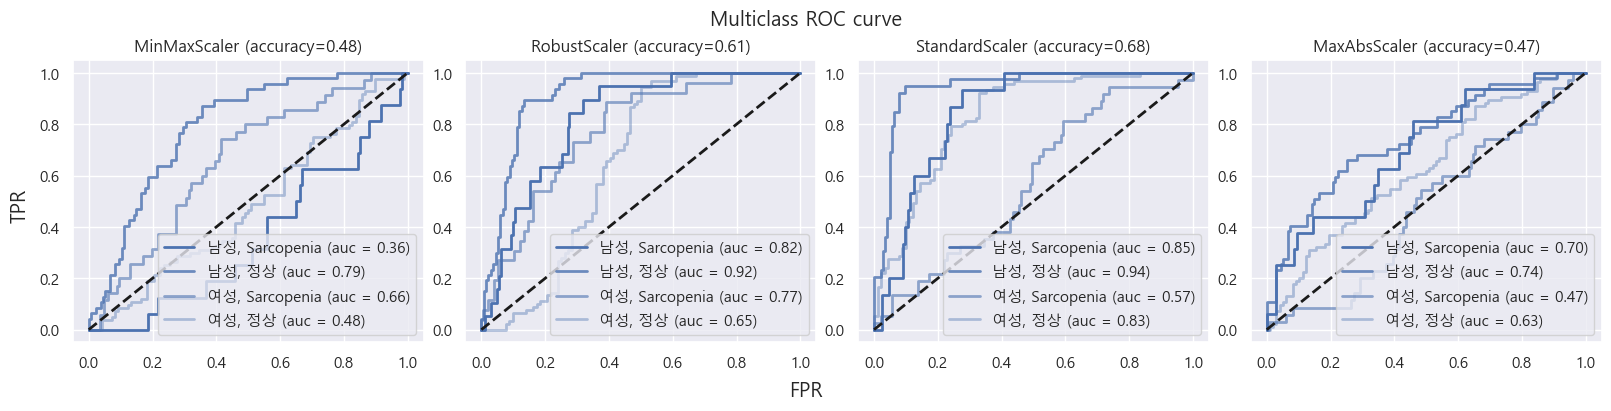

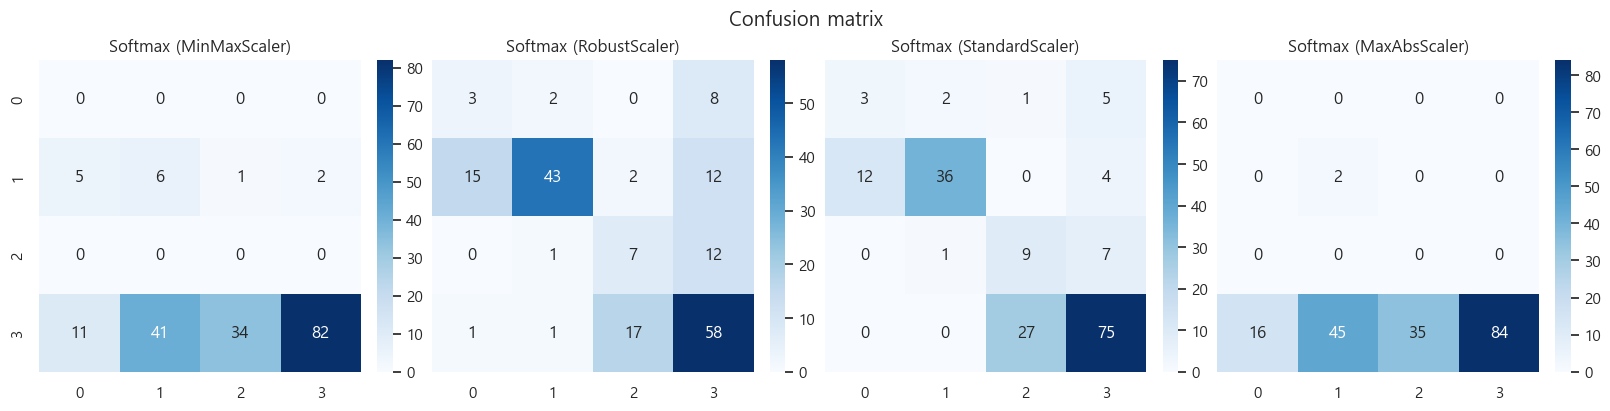

In [48]:
ml = model(
    koges=kg_stats,
    scalers=["minmax", "robust", "standard", "maxabs"],
)

if kg_stats.type == "binary":
    ml.logistic(isdisplay=True)
elif kg_stats.type == "discrete":
    ml.softmax(
        display_roc_curve=True,
        display_confusion_matrix=True,
    )
elif kg_stats.type == "continuous":
    ml.linear(isdisplay=True)
    # regression의 결과가 안좋은 경우 classification도 진행합니다.
    if ml.r2 < 0.8:
        if kg_stats.n_class == 2:
            ml.logistic(isdisplay=True)
        else:
            ml.softmax(
                display_roc_curve=True,
                display_confusion_matrix=True,
            )

### 6. 결과 저장

In [47]:
ml.equation(isdisplay=True)
kg_stats.save(isdisplay=False, issave=True)

<IPython.core.display.Math object>

Saving result:   0%|          | 0/11 [00:00<?, ?it/s]